# Многоклассовая классификация при дисбалансе классов

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from tqdm import tqdm

In [2]:
pd.options.mode.chained_assignment = None 

In [3]:
RANDOM_STATE = 42
TRAIN_SIZE = 0.75
rng = np.random.default_rng(RANDOM_STATE)

## 1. Загрузка и предварительный анализ данных

In [4]:
from sklearn.datasets import load_wine

data = load_wine(as_frame=True)

X = data.data
y = data.target

Посмотрим, какие признаки содержит датасет, а также тип данных и наличие пропусков

In [5]:
X.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


Переименуем некоторые колонки со слишком длинными названиями

In [6]:
X.rename(columns={'alcalinity_of_ash': 'alk_ash', 'nonflavanoid_phenols': 'nonfl_phen', 'color_intensity': 'color_int',
                  'proanthocyanins': 'pr_an_cyan', 'od280/od315_of_diluted_wines': 'od280_od315'}, inplace=True)

In [7]:
X.head()

,alcohol,malic_acid,ash,alk_ash,magnesium,total_phenols,flavanoids,nonfl_phen,pr_an_cyan,color_int,hue,od280_od315,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [8]:
# тип данных
X.dtypes

alcohol          float64
malic_acid       float64
ash              float64
alk_ash          float64
magnesium        float64
total_phenols    float64
flavanoids       float64
nonfl_phen       float64
pr_an_cyan       float64
color_int        float64
hue              float64
od280_od315      float64
proline          float64
dtype: object

Все признаки являются вещественными числами. Таким образом, нет необходимости в кодировке

In [9]:
# наличие пропусков
X.isna().sum()

alcohol          0
malic_acid       0
ash              0
alk_ash          0
magnesium        0
total_phenols    0
flavanoids       0
nonfl_phen       0
pr_an_cyan       0
color_int        0
hue              0
od280_od315      0
proline          0
dtype: int64

Датасет содержит только числовые данные. Пропуски отсутствуют

Проверим количество классов в целевой переменной

In [10]:
y.value_counts()

target
1    71
0    59
2    48
Name: count, dtype: int64

Таким образом, мы работаем с задачей **многоклассовой классификации**.

Следует также отметить, что в целевой переменной **классы не очень сбалансированы**. Поэтому accuracy будет плохо работать как метрика качества модели. Поскольку у нас нет конкретных требований, чему уделить внимание (precision или recall), то в качестве метрики будем использовать `f1-score`. 

## 2. EDA и подготовка данных

Разбиваем данные на тренировочную и тестовую выборки. Так как классы несбалансированы, задаем атрибут `stratify`, чтобы при разбиении сохранилось соотношение классов

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = RANDOM_STATE, stratify=y)

Дальнейший анализ будем выполнять для обучающей выборки

Проверим попарную корреляцию признаков

In [12]:
corr = X_train.corr()
corr.style.background_gradient(cmap='coolwarm')

,alcohol,malic_acid,ash,alk_ash,magnesium,total_phenols,flavanoids,nonfl_phen,pr_an_cyan,color_int,hue,od280_od315,proline
alcohol,1.000000,0.048448,0.288015,-0.286914,0.268460,0.311278,0.287921,-0.147389,0.095828,0.526565,-0.067012,0.097818,0.646587
malic_acid,0.048448,1.000000,0.154892,0.275699,-0.045455,-0.317934,-0.375415,0.217966,-0.215259,0.210404,-0.561199,-0.360611,-0.201228
ash,0.288015,0.154892,1.000000,0.442529,0.235842,0.133245,0.080593,0.188777,-0.012200,0.271603,-0.075389,-0.053457,0.229329
alk_ash,-0.286914,0.275699,0.442529,1.000000,-0.090453,-0.291692,-0.372614,0.329221,-0.173944,-0.016130,-0.251954,-0.285893,-0.462029
magnesium,0.268460,-0.045455,0.235842,-0.090453,1.000000,0.200909,0.161697,-0.277451,0.256439,0.189974,0.052314,0.032602,0.401703
total_phenols,0.311278,-0.317934,0.133245,-0.291692,0.200909,1.000000,0.858793,-0.407187,0.592119,-0.053982,0.434608,0.695982,0.496940
flavanoids,0.287921,-0.375415,0.080593,-0.372614,0.161697,0.858793,1.000000,-0.511695,0.653958,-0.185480,0.557284,0.784959,0.502657
nonfl_phen,-0.147389,0.217966,0.188777,0.329221,-0.277451,-0.407187,-0.511695,1.000000,-0.325089,0.119873,-0.231407,-0.490324,-0.298110
pr_an_cyan,0.095828,-0.215259,-0.012200,-0.173944,0.256439,0.592119,0.653958,-0.325089,1.000000,-0.068963,0.333344,0.508270,0.294190
color_int,0.526565,0.210404,0.271603,-0.016130,0.189974,-0.053982,-0.185480,0.119873,-0.068963,1.000000,-0.553938,-0.433048,0.302882


Имеет место достаточно сильная корреляция между признаками `'total_phenols'` и `'flavanoids'`. На практике, если значение коэффициента корреляции больше 0.9, то рекомендуют один из признаков удалить (хотя в некоторых задачах, например, связанных с кредитным скорингом, порог значительно ниже). В данном случае коэффициент корреляции 0.86, так что пока что оставим оба признака.

Проверим распределение величин, чтобы визуально оценить наличие выбросов

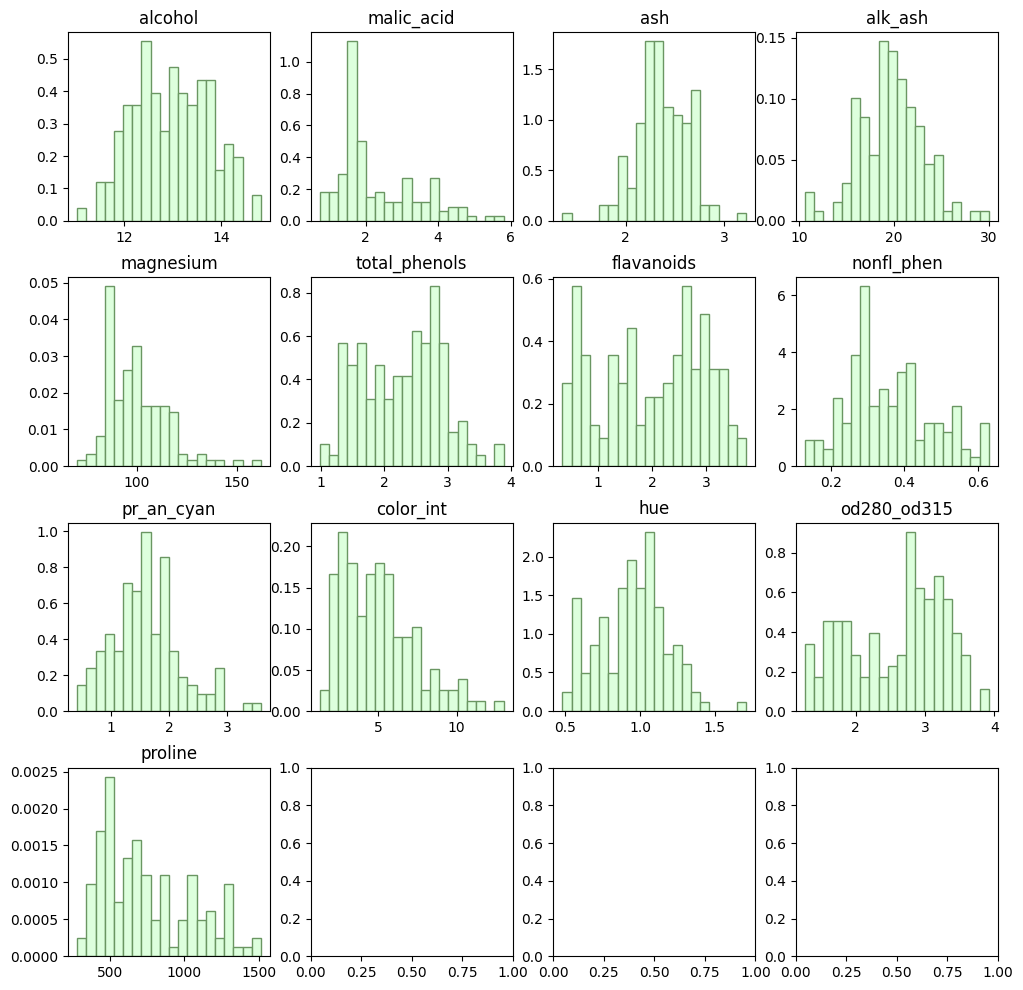

In [13]:
from matplotlib import pyplot as plt

fig, a = plt.subplots(4, 4, figsize=(12, 12))
plt.subplots_adjust(wspace=0.2, hspace=0.3)

for i in range(4):
    for j in range(4):
        if i*4+j < 13:
            a[i, j].set_title(X_train.columns[i*4+j])
            a[i, j].hist(X_train[X_train.columns[i*4+j]], bins=20, 
                         density=True, 
                         stacked=True, 
                         edgecolor="#6A9662",
                         color="#DDFFDD")

Из графиков видим, что есть единичные отдельно стоящие объекты по признакам `hue`, `ash`, `pr_an_cyan`. Посмтрим, что это за объекты

In [14]:
X_train[X_train.hue>1.5]

,alcohol,malic_acid,ash,alk_ash,magnesium,total_phenols,flavanoids,nonfl_phen,pr_an_cyan,color_int,hue,od280_od315,proline
115,11.03,1.51,2.2,21.5,85.0,2.46,2.17,0.52,2.01,1.9,1.71,2.87,407.0


In [15]:
X_train[(X_train.ash<1.5) | (X_train.ash>3)]

,alcohol,malic_acid,ash,alk_ash,magnesium,total_phenols,flavanoids,nonfl_phen,pr_an_cyan,color_int,hue,od280_od315,proline
25,13.05,2.05,3.22,25.0,124.0,2.63,2.68,0.47,1.92,3.58,1.13,3.20,830.0
59,12.37,0.94,1.36,10.6,88.0,1.98,0.57,0.28,0.42,1.95,1.05,1.82,520.0


In [16]:
X_train[X_train.pr_an_cyan>3]

,alcohol,malic_acid,ash,alk_ash,magnesium,total_phenols,flavanoids,nonfl_phen,pr_an_cyan,color_int,hue,od280_od315,proline
95,12.47,1.52,2.20,19.0,162.0,2.50,2.27,0.32,3.28,2.6,1.16,2.63,937.0
110,11.46,3.74,1.82,19.5,107.0,3.18,2.58,0.24,3.58,2.9,0.75,2.81,562.0


Видим, что специфическими свойствами обладают разные объекты, при этом хотя свойства этих объектов и отличаются от общей совокупности, но не сильно. Проверим дополнительно статистические характеристики признаков

In [17]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
alcohol,133.0,12.968271,0.801903,11.03,12.37,12.99,13.56,14.83
malic_acid,133.0,2.332932,1.090271,0.74,1.61,1.81,3.12,5.80
ash,133.0,2.367744,0.266693,1.36,2.20,2.36,2.56,3.22
alk_ash,133.0,19.701504,3.366389,10.60,17.20,20.00,21.50,30.00
magnesium,133.0,100.000000,14.982313,70.00,88.00,98.00,108.00,162.00
total_phenols,133.0,2.282481,0.630004,0.98,1.70,2.40,2.80,3.88
flavanoids,133.0,1.993383,0.958150,0.34,1.22,2.14,2.78,3.74
nonfl_phen,133.0,0.361429,0.118534,0.13,0.27,0.34,0.43,0.63
pr_an_cyan,133.0,1.604586,0.585901,0.42,1.25,1.57,1.95,3.58
color_int,133.0,5.007820,2.365661,1.28,3.05,4.68,6.25,13.00


В целом видим, что необходимости в дополнительной очистке данных нет.

Вместе с тем для некоторых моделей необходимо выполнить масштабирование данных (в частности, это актуально для линейных моделей и KNN)

In [18]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# 3. Построение модели

В рамках данного проекта будем рассматривать 4 модели: логистическую регрессию, метод опорных векторов, KNN и дерево решений.

## 3.1 Логистическая регрессия

В `scikit-learn` многоклассовая классификация для логистической регрессии реализована через атрибут `multi_class`, который может принимать значения `ovr` (One-versus-rest подход для перехода к совокупности задач бинарной классификации), `multinomial` (прямое решение задачи многоклассовой классификации, где в качестве функции потерь применяется кросс-энтропия).

Сравним качество двух соответствующих моделей посредством кросс-валидации. Поскольку есть дисбаланс классов, то задаем атрибут модели `class_weight='balanced'` (устраняет дисбалланс классов путем присвоения классам весов, обратно пропорциональных долям этих классов), а в качестве метрики возьмем `f1_weighted`, то есть взвешенную метрику f1. Для разбиения по кросс-валидации выбираем опцию `StratifiedKFold()`, поскольку она позволяет сохранить баланс классов в фолдах

In [19]:
cross_val_score(LogisticRegression(multi_class='ovr', class_weight='balanced'), 
                X_train_scaled, y_train, cv=StratifiedKFold(n_splits=5), scoring='f1_weighted', verbose=2).mean()

[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


0.9772812372812373

In [20]:
cross_val_score(LogisticRegression(multi_class='multinomial', class_weight='balanced'), 
                X_train_scaled, y_train, cv=StratifiedKFold(n_splits=5), scoring='f1_weighted', verbose=2).mean()

[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


0.9772812372812373

 Выполним подбор коэффициента регуляризации `С` с помощью `GridSearchCV`

In [21]:
params = {'C' : np.arange(0.01, 1, 0.05)} 

gs_logreg = GridSearchCV(LogisticRegression(multi_class='ovr', class_weight='balanced'), 
                         params, cv=StratifiedKFold(n_splits=5), scoring='f1_weighted')

gs_logreg.fit(X_train_scaled, y_train)

print(gs_logreg.best_score_) 
print(gs_logreg.best_params_) 

0.9773041704311055
{'C': 0.060000000000000005}


Значение целевой метрики чуть улучшилось

Возьмем в качестве конечной модели - лучшую модель, обученную при GridSearchCV. Посчитаем для нее значение целевой метрики на тестовой выборке

In [22]:
log_reg_model = gs_logreg.best_estimator_
log_reg_model

LogisticRegression(C=0.060000000000000005, class_weight='balanced',
                   multi_class='ovr')

In [23]:
pred_logreg = log_reg_model.predict(X_test_scaled)

f1_weighted_logreg = f1_score(y_test, pred_logreg, average='weighted')
print(f1_weighted_logreg)

1.0


Отличный результат! Но посмотрим, как сработают на данной задаче другие модели

## 3.2 Метод опорных векторов (SVM)

Метод опорных векторов работает достаточно медленно. Подключим библиотеку `sklearn intelex` для ускорения обучения SVM (в некоторых источниках говорят, что позволяет ускорить работу метода в 600 раз)

In [24]:
# %%capture
# !pip install --upgrade scikit-learn-intelex

In [25]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [26]:
import sys
import os
import site

sys.path.append(os.path.join(os.path.dirname(site.getsitepackages()[0]), "site-packages"))

В `scikit-learn` метод опорных векторов для классификации реализован через класс `SVM`, в котором нет атрибута `multi_class` или его аналога. Вместе с тем метод опорных векторов можно использовать и для многоклассовой классификации, если обернуть его в один из классов `OneVsRestClassifier` или `OneVsOneClassifier` из `sklearn.multiclass`.
Проверим на кросс-валидации, какой из подходов one-vs-rest или one-vs-one будет работать лучше, с параметрами метода опорных векторов по умолчанию. Заодно засечем время обучения модели

In [27]:
%%time

cross_val_score(OneVsRestClassifier(SVC(class_weight='balanced')), X_train_scaled, y_train, 
                cv=StratifiedKFold(n_splits=5), scoring='f1_weighted', verbose=2).mean()

[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
CPU times: total: 78.1 ms
Wall time: 69.6 ms


0.9923809523809524

In [28]:
%%time

cross_val_score(OneVsOneClassifier(SVC(class_weight='balanced')), X_train_scaled, y_train, 
                cv=StratifiedKFold(n_splits=5), scoring='f1_weighted', verbose=2).mean()

[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
CPU times: total: 62.5 ms
Wall time: 52.6 ms


0.9923809523809524

Поскольку у нас небольшой датасет, модель обучилась очень быстро. И значение целевой метрики очень высокое. Разницы между тем, какой подход one-vs-rest или one-vs-one применять нет, но это достаточно ожидаемо: one-vs-rest хуже работает при большом датасете, а one-vs-one - при большом количестве классов. В рассматриваемой задаче датасет достаточно небольшой и количество классов малое.

Теперь можно подобрать оптимальные параметры, но `GridSearchCV` в данном случае не сработает, т.к. в модели, например, OneVsRestClassifier(SVC()) он будет ожидать атрибуты `OneVsRestClassifier()`, а нам необходимо подобрать параметры для `SVC()`. Сделаем это при помощи перебора в циклах, а расчет целевой метрики будем выполнять по кросс-валидации.

Определим наилучшие значения:

- ядра ядра из перечня ('rbf','poly','sigmoid','linear')
- коэффициента регуляризации из диапазона (0.01 до 5.01 с шагом 0.1)

Чтобы удобнее было следить за програссом, обернем итератор внешнего цикла в `tqdm`

In [29]:
kernels = ['rbf', 'poly', 'sigmoid', 'linear']
best_f1_w, best_C, best_kernel = 0, 0, 0

for C in tqdm(np.arange(0.01, 5.01, 0.1)):
    for kernel in kernels:
        f1_w = cross_val_score(OneVsRestClassifier(SVC(class_weight='balanced', C=C, kernel=kernel)), 
                               X_train_scaled, y_train, cv=StratifiedKFold(n_splits=5), scoring='f1_weighted', verbose=1).mean()
        if f1_w > best_f1_w:
            best_C = C
            best_kernel = kernel
            best_f1_w = f1_w
print(f'best_C = {best_C}\nbest_kernel = {best_kernel}\nbest_f1_score = {best_f1_w}')

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.21it/s]

best_C = 0.31000000000000005
best_kernel = linear
best_f1_score = 0.9925925925925926


Качество модели немного улучшилось. Обучим модель с найденными лучшими параметрами и найдем предсказание на тестовой выборке

In [30]:
svm_model = OneVsRestClassifier(SVC(class_weight='balanced', C=0.31, kernel='linear'))
svm_model.fit(X_train_scaled, y_train)

OneVsRestClassifier(estimator=SVC(C=0.31, class_weight='balanced',
                                  kernel='linear'))

In [31]:
pred_svm = svm_model.predict(X_test_scaled)

f1_weighted_svm = f1_score(y_test, pred_svm, average='weighted')
print(f1_weighted_svm)

0.955430886707184


Качество построенной модели высокое, но несколько ниже, чем у модели логистической регрессии. Посмотрим, какие классы путает модель

In [32]:
print(confusion_matrix(y_test, pred_svm))

[[15  0  0]
 [ 1 17  0]
 [ 0  1 11]]


Строки - реальные значения классов 0, 1, 2. Столбцы - прогноз. Из второй и третьей строк видим, что на тестовой выборке 1 объект класса 1 был ошибочно отнесен к классу 0, а также 1 объект класса 2 был отнесен к классу 1. То есть в целом модель работает неплохо, но заметно хуже, чем модель логистической регрессии

## 3.3 KNN

Проверим, какое качество по кросс-валидации на обучающей выборке даст алгоритм KNN с параметрами по умолчанию

In [33]:
cross_val_score(KNeighborsClassifier(), X_train_scaled, y_train, cv=StratifiedKFold(n_splits=5), scoring='f1_weighted', verbose=2).mean()

[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


0.946659433904016

С помощью GridSearchCV подберем оптимальные параметры:
-  количество соседей (`n_neighbors`) из диапазона (от 3 до 30 с шагом 1)
-  параметр `weights` из `uniform`, `distance`. Таким образом определим, следует ли учитывать в модели веса объектов, рассчитаные на основе расстояния до них

In [34]:
params = {'n_neighbors' : np.arange(3, 30, 1), 'weights': ['uniform', 'distance']} 

gs_knn = GridSearchCV(KNeighborsClassifier(), params, cv=StratifiedKFold(n_splits=5), scoring='f1_weighted')

gs_knn.fit(X_train_scaled, y_train)

print(gs_knn.best_score_) 
print(gs_knn.best_params_) 

0.9772998022120829
{'n_neighbors': 11, 'weights': 'uniform'}


Получаем, что оптимальное количество соседей составляет 11, а веса объектов можно не учитывать и оставить значение данного параметра по умолчанию `uniform`.

Возьмем в качестве конечной модели - лучшую модель, обученную при GridSearchCV. Посчитаем для нее значение целевой метрики на тестовой выборке

In [35]:
knn_model = gs_knn.best_estimator_
knn_model

KNeighborsClassifier(n_neighbors=11)

In [36]:
pred_knn = knn_model.predict(X_test_scaled)

f1_weighted_knn = f1_score(y_test, pred_knn, average='weighted')
print(f1_weighted_knn)

0.9779047619047618


Качество на тестовой выборке лучше, чем у модели, построенной на базе метода опорных векторов, но чуть хуже, чем у модели логистической регрессии

In [37]:
print(confusion_matrix(y_test, pred_knn))

[[15  0  0]
 [ 0 17  1]
 [ 0  0 12]]


Строки - реальные значения классов 0, 1, 2. Столбцы - прогноз. Из второй строки видим, что только 1 объект класса 1 был ошибочно отнесен к классу 2. То есть в целом модель работает хорошо.

Посмотрим результаты из `classification_report`

In [38]:
print(classification_report(y_test, pred_knn))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      0.94      0.97        18
           2       0.92      1.00      0.96        12

    accuracy                           0.98        45
   macro avg       0.97      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



Из значений `precision` и `recall` видим, что для класса 1 снижено значение `recall` за счет наличия 1 *false negative* значения предсказания, а у класса 2 снижено значение `precision` за счет наличия 1 *false positive* предсказания.

## 3.4 Дерево решений

В рамках данного проекта будем рассматривать простое дерево решений, без композиций

Поскольку дерево решений склонно к переобучению, то не будем проверять качество модели с параметрами по умолчанию, а сразу с помощью `GridSearchCV` будем искать оптимальные параметры для модели 

In [39]:
params = {'max_depth' : np.arange(2,10),
          'criterion' : ['gini', 'entropy', 'log_loss'],
          'min_samples_split' : np.arange(2,10,1),
          'min_samples_leaf': np.arange(2,10,1)}

gs_tree = GridSearchCV(DecisionTreeClassifier(class_weight='balanced'), params, cv=StratifiedKFold(n_splits=5), scoring='f1_weighted')

gs_tree.fit(X_train_scaled, y_train)

print(gs_tree.best_score_) 
print(gs_tree.best_params_) 

0.9177261229556979
{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 6, 'min_samples_split': 2}


Качество деревянной модели значительно уступает ранее рассмотренным моделям. Проверим целевую метрику лучшей модели дерева на тестовой выборке

In [40]:
tree_model = gs_tree.best_estimator_
tree_model

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=3, min_samples_leaf=6)

In [41]:
pred_tree = tree_model.predict(X_test_scaled)

f1_weighted_tree = f1_score(y_test, pred_tree, average='weighted')
print(f1_weighted_tree)

0.8868686868686868


В целом нельзя сказать, что дерево переобучилось. Визуализируем построенное дерево

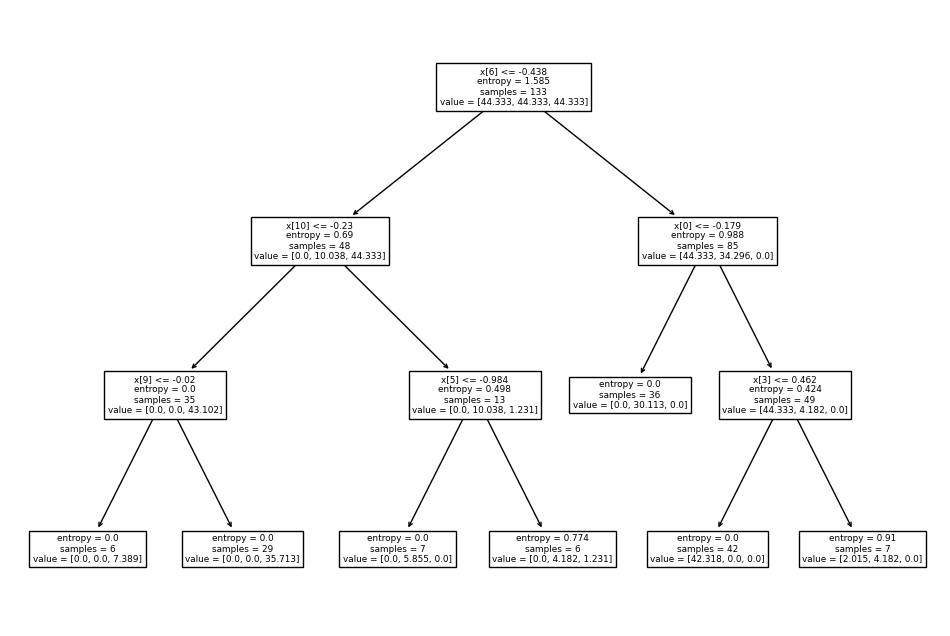

In [42]:
from sklearn.tree import plot_tree

plt.figure(figsize=(12,8))
plot_tree(tree_model) 
None

Как видно из представленной визуализации, полученное дерево решений достаточно компактное, возможностей для его дальнейшего улучшения (например, прунингом) не просматривается.
Посмотрим, на каких классах ошибается модель

In [43]:
print(confusion_matrix(y_test, pred_tree))

[[15  0  0]
 [ 3 14  1]
 [ 0  1 11]]


Модель определяет объекты 0-го класса безошибочно. Хуже всего она отличает объекты класса 1. Возможно, улучшить ситуацию позволил бы подбор весовых коэффициентов для классов с помощью `GridSearchCV`. Композиции деревьев также показали бы лучший результат, чем отдельное дерево, но не будем их рассматривать, принимая во внимание что в рамках данного проекта уже получена модель с максимально возможным значением целевой метрики (логистическая регрессия).

# Выводы

В рамках данного проекта был рассмотрен датасет с характеристиками вина `load_wine` из библиотеки `sklearn.datasets`.

Выполненный анализ датасета (EDA) показ, что наибольшая корреляция имеет место для признаков `total_phenols` и `flavanoids`. Но принимая во внимание, что коэффициент корреляции ниже 0.9 принято решение оставить для дальнейшей обработки все признаки. Выбросов в данных также не обнаружено. Выполнена стандартизация датасета.

Установлено, что рассматриваемая задача определения класса вида относится к многоклассовой классификации. Целевая переменная представлена 3 классами (0, 1, 2). Отмечено наличие дисбаланса классов. Поэтому в качестве целевой метрики принята метрика `f1_weighted` (взвешенный f1-score).

Построена модель логистической регрессии. По кроссвалидации показано, что в рассматриваемой задаче применение подходов one-versus-rest и one-versus-one для перехода к бинарной классификации равнозначно, т.к. не дает прироста целевой метрики. На основании перебора по кроссвалидации (с применением `GridSearchCV`) получено оптимальное значение коэффициента регуляризации С=0.06. `f1_weighted` для построенной модели на тестовой выборке составил 1.

Построена модель многоклассовой классификации на основе метода опорных векторов. Принимая во внимание, что в `scikit-learn` метод опорных векторов для классификации реализован через класс `SVM`, в котором нет атрибута `multi_class` или его аналога, была создана комплексная модель `OneVsRestClassifier(SVC())`. Поскольку в данном случае применнение `GridSearchCV` к модели `SVC()` невозможно, подбор по кросс-валидации параметров для созданной модели был реализован в явном виде. В результате в качестве оптимальной принята модель с линейным ядром и коэффициентом регуляризации `C=0.31`. Целевая метрика `f1_weighted` для построенной модели на тестовой выборке составила 0,96. Более детальный анализ показал, что модель неверно классифицировала по 1 объекту из класса 1 и класса 2. Объекты класса 0 тестовой выборки были классифицированы безошибочно.

Построена модель многоклассовой классификации на основе алгоритма KNN. Перебором по кросс-валидации получено оптимальное количество соседей `n_neighbors=11`, а также метод определения весовых коэффициентов для соседей. Целевая метрика `f1_weighted` для построенной модели на тестовой выборке составила 0,98. Более детальный анализ показал, что модель неверно классифицировала только 1 объект класса 1 (ошибочно отнесен к классу 2). То есть в целом модель работает хорошо.

Построена модель классификации на основе дерева решений и выполнен подбор оптимальных параметров. Наибольшее значение метрики `f1_weighted`, которое было достигнуто на тестовой выборке для данной модели составило 0.89, что существенно хуже, чем у ранее рассмотренных моделей. Модель безошибочно классифицировала объекты класса 0, но сравнительно плохо определяла объекты класса 1 (true positive = 14, false negative = 4). Модель может быть улучшена путем подбора оптимальных весовых коэффициентов для классов, а также переходом к композициям деревьев. Вместе с тем обучение дерева занимает больше времени, чем логистической регрессии.

Таким образом, **в качестве окончательной модели принята модель, построенная на основе логистической регрессии с коэффициентом регуляризации С=0.06, автоматической балансировкой данных (class_weight='balanced') и one-versus-rest подходом для учета многоклассовой постановки задачи (multi_class='ovr'), безошибочно классифицировавшая все объекты тестовой выборки**.

### Дополнительные источники:
Хорошая статья по работе с дисбалансом классов https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/ 